In [ ]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

In [49]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor



def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 10
tfdict = {"M5":0, "M15":1, "H1":2}
Xl, Xs, yl, ys, odates, poslist = [], [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[:-2]/f.Close[-2]
        fo = f.Open[:-2]/f.Open[-2]
        fh = f.High[:-2]/f.High[-2]
        fl = f.Low[:-2]/f.Low[-2]
        fv = f.Volume[:-2]/f.Volume[-2] if f.Volume[-2] != 0 else f.Volume[:-2]*0
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)
odates = np.array(odates)

# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER 696
ROSN 478
LKOH 505
GMKN 467
GAZP 456
SBER 653
ROSN 444
LKOH 464
GMKN 444
GAZP 423
SBER 635
ROSN 430
LKOH 440
GMKN 425
GAZP 398
SBER 637
ROSN 433
LKOH 452
GMKN 411
GAZP 396
SBER 584
ROSN 396
LKOH 405
GMKN 382
GAZP 351
SBER 550
ROSN 373
LKOH 366
GMKN 364
GAZP 322
SBER 604
ROSN 398
LKOH 417
GMKN 384
GAZP 370
SBER 545
ROSN 351
LKOH 367
GMKN 349
GAZP 320
SBER 507
ROSN 326
LKOH 325
GMKN 323
GAZP 290
(8778, 54) (10833, 54) (19611, 54) (8778,) (10833,) (19611,)


In [73]:
nitrers = 1
test_split = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, -2]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]
    profs_test = y_test
    profs_train = y_train
    # y_train = (y_train > 0).astype(int)
    # y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])
    
    print(X_train.shape[0], X_test.shape[0])
    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=500,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # lgb.plot_metric(evals_result, metric='f1')

    model = RandomForestRegressor(max_depth=30, n_estimators=300, min_samples_leaf=10)
    model.fit(X_train, y_train)
    threshold = -0.5
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model.predict(X_train)
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model.predict(X_test)
    metrics[1, i] = mean_absolute_error(p_test, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
# plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
# plt.plot([0, 100], [threshold, threshold])

14678 4933


000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 :+1034.5 ->  +776.2 --
[   0.            0.         1034.48209302]  ->  [  0.           0.         776.15470691]
[        nan         nan -0.24971663]
av. profit boost: -0.24971663391096083


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_7355/3826407786.py:12: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


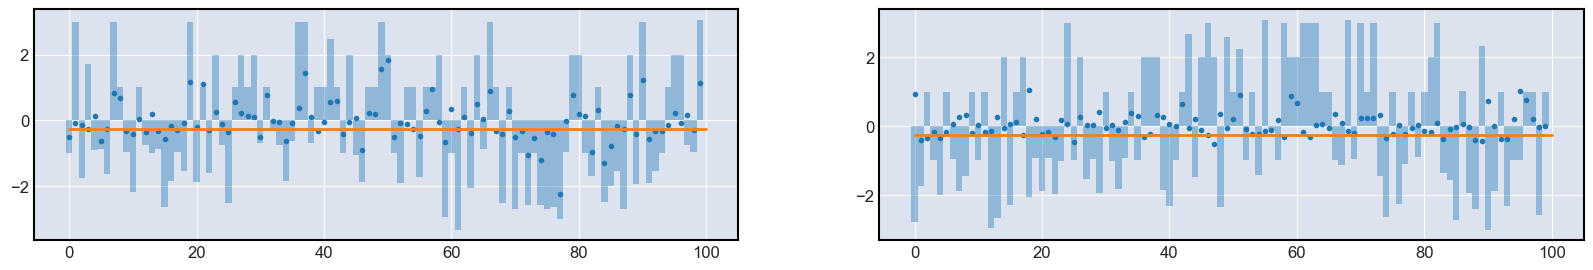

In [64]:
threshold = -0.25
for j in range(3):
    ids = tf_test == j
    pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
    gprofits[j, i] = profs_test[ids].sum()
    print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [26]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

{1, 2, 3}

In [27]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0155 0.0155 0.0163 0.0170 0.0167 0.0167 0.0163 0.0169 0.0188 0.0164 0.0161 0.0161 0.0162 0.0162 0.0192 0.0183 0.0218 0.0186 0.0192 0.0194 0.0168 0.0146 0.0165 0.0157 0.0180 0.0189 0.0176 0.0195 0.0208 0.0211 0.0166 0.0154 0.0178 0.0165 0.0184 0.0174 0.0177 0.0193 0.0177 0.0183 0.0175 0.0173 0.0172 0.0160 0.0162 0.0175 0.0182 0.0165 0.0197 0.0175 0.0467 0.0780


In [391]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])